In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as data
from matplotlib import pyplot as plt
%matplotlib inline

from datetime import datetime
from datetime import timedelta

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.layers import Input, SimpleRNN, GRU, LSTM, Dense
from tensorflow.keras.layers import Dropout, Flatten, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam

import tensorflow as tf

## 데이터 수집

In [2]:
start = '2005-01-01'
end = '2022-01-01'

df = data.DataReader('AAPL.US', 'stooq', start, end)
df.to_csv('APPLE.csv')

In [3]:
df = pd.read_csv('APPLE.csv')
df

,Date,Open,High,Low,Close,Volume
0,2021-12-31,178.0850,179.2300,177.2600,177.5700,64062261
1,2021-12-30,179.4700,180.5700,178.0900,178.2000,59773014
2,2021-12-29,179.3300,180.6300,178.1400,179.3800,62348931
3,2021-12-28,180.1600,181.3300,178.5300,179.2900,79144339
4,2021-12-27,177.0850,180.4200,177.0700,180.3300,74919582
...,...,...,...,...,...,...
4275,2005-01-07,0.9958,1.0658,0.9916,1.0601,2607118863
4276,2005-01-06,0.9921,0.9935,0.9693,0.9881,822930454
4277,2005-01-05,0.9788,0.9988,0.9788,0.9875,793814983
4278,2005-01-04,0.9760,1.0023,0.9640,0.9788,1280464965


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4280 entries, 0 to 4279
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    4280 non-null   object 
 1   Open    4280 non-null   float64
 2   High    4280 non-null   float64
 3   Low     4280 non-null   float64
 4   Close   4280 non-null   float64
 5   Volume  4280 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 200.8+ KB


## 데이터 전처리 

In [5]:
# datetime 자료형으로 변경
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4280 entries, 0 to 4279
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    4280 non-null   datetime64[ns]
 1   Open    4280 non-null   float64       
 2   High    4280 non-null   float64       
 3   Low     4280 non-null   float64       
 4   Close   4280 non-null   float64       
 5   Volume  4280 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 200.8 KB


In [6]:
# 요일정보 추가 (월:0, 화:1, 수:2, 목:3, 금:4, 토:5, 일:6)
df['weekday'] = df['Date'].dt.weekday
df

,Date,Open,High,Low,Close,Volume,weekday
0,2021-12-31,178.0850,179.2300,177.2600,177.5700,64062261,4
1,2021-12-30,179.4700,180.5700,178.0900,178.2000,59773014,3
2,2021-12-29,179.3300,180.6300,178.1400,179.3800,62348931,2
3,2021-12-28,180.1600,181.3300,178.5300,179.2900,79144339,1
4,2021-12-27,177.0850,180.4200,177.0700,180.3300,74919582,0
...,...,...,...,...,...,...,...
4275,2005-01-07,0.9958,1.0658,0.9916,1.0601,2607118863,4
4276,2005-01-06,0.9921,0.9935,0.9693,0.9881,822930454,3
4277,2005-01-05,0.9788,0.9988,0.9788,0.9875,793814983,2
4278,2005-01-04,0.9760,1.0023,0.9640,0.9788,1280464965,1


In [7]:
start = datetime(2005, 1, 3)
df['weeks'] = (df['Date'] - start) // timedelta(weeks=1)
df

,Date,Open,High,Low,Close,Volume,weekday,weeks
0,2021-12-31,178.0850,179.2300,177.2600,177.5700,64062261,4,886
1,2021-12-30,179.4700,180.5700,178.0900,178.2000,59773014,3,886
2,2021-12-29,179.3300,180.6300,178.1400,179.3800,62348931,2,886
3,2021-12-28,180.1600,181.3300,178.5300,179.2900,79144339,1,886
4,2021-12-27,177.0850,180.4200,177.0700,180.3300,74919582,0,886
...,...,...,...,...,...,...,...,...
4275,2005-01-07,0.9958,1.0658,0.9916,1.0601,2607118863,4,0
4276,2005-01-06,0.9921,0.9935,0.9693,0.9881,822930454,3,0
4277,2005-01-05,0.9788,0.9988,0.9788,0.9875,793814983,2,0
4278,2005-01-04,0.9760,1.0023,0.9640,0.9788,1280464965,1,0


In [8]:
df = df[['Date', 'weeks', 'weekday', 'High', 'Low', 'Open', 'Close']]
df

,Date,weeks,weekday,High,Low,Open,Close
0,2021-12-31,886,4,179.2300,177.2600,178.0850,177.5700
1,2021-12-30,886,3,180.5700,178.0900,179.4700,178.2000
2,2021-12-29,886,2,180.6300,178.1400,179.3300,179.3800
3,2021-12-28,886,1,181.3300,178.5300,180.1600,179.2900
4,2021-12-27,886,0,180.4200,177.0700,177.0850,180.3300
...,...,...,...,...,...,...,...
4275,2005-01-07,0,4,1.0658,0.9916,0.9958,1.0601
4276,2005-01-06,0,3,0.9935,0.9693,0.9921,0.9881
4277,2005-01-05,0,2,0.9988,0.9788,0.9788,0.9875
4278,2005-01-04,0,1,1.0023,0.9640,0.9760,0.9788


In [9]:
# 가장 오래된 날짜를 먼저 표시되도록 정렬 
df.sort_values(by='Date', ascending=True, inplace=True)
df

/opt/anaconda3/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,Date,weeks,weekday,High,Low,Open,Close
4279,2005-01-03,0,0,0.9967,0.9585,0.9930,0.9687
4278,2005-01-04,0,1,1.0023,0.9640,0.9760,0.9788
4277,2005-01-05,0,2,0.9988,0.9788,0.9788,0.9875
4276,2005-01-06,0,3,0.9935,0.9693,0.9921,0.9881
4275,2005-01-07,0,4,1.0658,0.9916,0.9958,1.0601
...,...,...,...,...,...,...,...
4,2021-12-27,886,0,180.4200,177.0700,177.0850,180.3300
3,2021-12-28,886,1,181.3300,178.5300,180.1600,179.2900
2,2021-12-29,886,2,180.6300,178.1400,179.3300,179.3800
1,2021-12-30,886,3,180.5700,178.0900,179.4700,178.2000


In [10]:
# Date컬럼을 인덱스로 변경 (set_index)
df.set_index(keys='Date', inplace=True)
df

,weeks,weekday,High,Low,Open,Close
Date,,,,,,
2005-01-03,0,0,0.9967,0.9585,0.9930,0.9687
2005-01-04,0,1,1.0023,0.9640,0.9760,0.9788
2005-01-05,0,2,0.9988,0.9788,0.9788,0.9875
2005-01-06,0,3,0.9935,0.9693,0.9921,0.9881
2005-01-07,0,4,1.0658,0.9916,0.9958,1.0601
...,...,...,...,...,...,...
2021-12-27,886,0,180.4200,177.0700,177.0850,180.3300
2021-12-28,886,1,181.3300,178.5300,180.1600,179.2900
2021-12-29,886,2,180.6300,178.1400,179.3300,179.3800


In [11]:
# 다음달의 종가하고 당일의 종가하고의 차를 계산하여 새로운 컬럼으로 추가
df_shift = df.shift(-1)
df_shift

,weeks,weekday,High,Low,Open,Close
Date,,,,,,
2005-01-03,0.0,1.0,1.0023,0.9640,0.9760,0.9788
2005-01-04,0.0,2.0,0.9988,0.9788,0.9788,0.9875
2005-01-05,0.0,3.0,0.9935,0.9693,0.9921,0.9881
2005-01-06,0.0,4.0,1.0658,0.9916,0.9958,1.0601
2005-01-07,1.0,0.0,1.0825,1.0392,1.0701,1.0559
...,...,...,...,...,...,...
2021-12-27,886.0,1.0,181.3300,178.5300,180.1600,179.2900
2021-12-28,886.0,2.0,180.6300,178.1400,179.3300,179.3800
2021-12-29,886.0,3.0,180.5700,178.0900,179.4700,178.2000


In [12]:
df['Gap_close'] = df_shift['Close'] - df['Close']
df

/var/folders/g5/jlzp3hhs653_qdq2kmf35jbh0000gn/T/ipykernel_61535/3866158222.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Gap_close'] = df_shift['Close'] - df['Close']


,weeks,weekday,High,Low,Open,Close,Gap_close
Date,,,,,,,
2005-01-03,0,0,0.9967,0.9585,0.9930,0.9687,0.0101
2005-01-04,0,1,1.0023,0.9640,0.9760,0.9788,0.0087
2005-01-05,0,2,0.9988,0.9788,0.9788,0.9875,0.0006
2005-01-06,0,3,0.9935,0.9693,0.9921,0.9881,0.0720
2005-01-07,0,4,1.0658,0.9916,0.9958,1.0601,-0.0042
...,...,...,...,...,...,...,...
2021-12-27,886,0,180.4200,177.0700,177.0850,180.3300,-1.0400
2021-12-28,886,1,181.3300,178.5300,180.1600,179.2900,0.0900
2021-12-29,886,2,180.6300,178.1400,179.3300,179.3800,-1.1800


In [13]:
# 새로운컬럼 Up을 추가하고, 올라갈경우 1, 내려갈경우 0
# Gap_close 삭제
df['Up'] = 0
df['Up'][df['Gap_close'] > 0] = 1
df.drop('Gap_close', axis=1, inplace=True)
df

/var/folders/g5/jlzp3hhs653_qdq2kmf35jbh0000gn/T/ipykernel_61535/1407238827.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Up'][df['Gap_close'] > 0] = 1


,weeks,weekday,High,Low,Open,Close,Up
Date,,,,,,,
2005-01-03,0,0,0.9967,0.9585,0.9930,0.9687,1
2005-01-04,0,1,1.0023,0.9640,0.9760,0.9788,1
2005-01-05,0,2,0.9988,0.9788,0.9788,0.9875,1
2005-01-06,0,3,0.9935,0.9693,0.9921,0.9881,1
2005-01-07,0,4,1.0658,0.9916,0.9958,1.0601,0
...,...,...,...,...,...,...,...
2021-12-27,886,0,180.4200,177.0700,177.0850,180.3300,0
2021-12-28,886,1,181.3300,178.5300,180.1600,179.2900,1
2021-12-29,886,2,180.6300,178.1400,179.3300,179.3800,0


<AxesSubplot:xlabel='Date'>

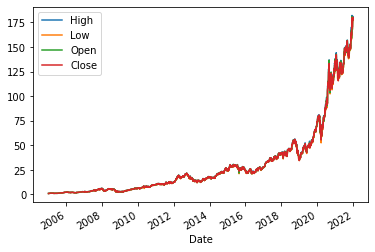

In [14]:
# High, Low, Open, Close -> line graph로 그려보기 
df_new = df[['High','Low','Open','Close']]
df_new.plot(kind='line')

In [15]:
df_shift = df.shift(1)
df_shift

,weeks,weekday,High,Low,Open,Close,Up
Date,,,,,,,
2005-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-04,0.0,0.0,0.9967,0.9585,0.9930,0.9687,1.0
2005-01-05,0.0,1.0,1.0023,0.9640,0.9760,0.9788,1.0
2005-01-06,0.0,2.0,0.9988,0.9788,0.9788,0.9875,1.0
2005-01-07,0.0,3.0,0.9935,0.9693,0.9921,0.9881,1.0
...,...,...,...,...,...,...,...
2021-12-27,885.0,3.0,176.8499,175.2700,175.8500,176.2800,1.0
2021-12-28,886.0,0.0,180.4200,177.0700,177.0850,180.3300,0.0
2021-12-29,886.0,1.0,181.3300,178.5300,180.1600,179.2900,1.0


In [16]:
df['Close_ratio'] = (df['Close'] - df_shift['Close']) / df_shift['Close']
df

,weeks,weekday,High,Low,Open,Close,Up,Close_ratio
Date,,,,,,,,
2005-01-03,0,0,0.9967,0.9585,0.9930,0.9687,1,NaN
2005-01-04,0,1,1.0023,0.9640,0.9760,0.9788,1,0.010426
2005-01-05,0,2,0.9988,0.9788,0.9788,0.9875,1,0.008888
2005-01-06,0,3,0.9935,0.9693,0.9921,0.9881,1,0.000608
2005-01-07,0,4,1.0658,0.9916,0.9958,1.0601,0,0.072867
...,...,...,...,...,...,...,...,...
2021-12-27,886,0,180.4200,177.0700,177.0850,180.3300,0,0.022975
2021-12-28,886,1,181.3300,178.5300,180.1600,179.2900,1,-0.005767
2021-12-29,886,2,180.6300,178.1400,179.3300,179.3800,0,0.000502


In [17]:
df['Body'] = df['Open'] - df['Close']
df

,weeks,weekday,High,Low,Open,Close,Up,Close_ratio,Body
Date,,,,,,,,,
2005-01-03,0,0,0.9967,0.9585,0.9930,0.9687,1,NaN,0.0243
2005-01-04,0,1,1.0023,0.9640,0.9760,0.9788,1,0.010426,-0.0028
2005-01-05,0,2,0.9988,0.9788,0.9788,0.9875,1,0.008888,-0.0087
2005-01-06,0,3,0.9935,0.9693,0.9921,0.9881,1,0.000608,0.0040
2005-01-07,0,4,1.0658,0.9916,0.9958,1.0601,0,0.072867,-0.0643
...,...,...,...,...,...,...,...,...,...
2021-12-27,886,0,180.4200,177.0700,177.0850,180.3300,0,0.022975,-3.2450
2021-12-28,886,1,181.3300,178.5300,180.1600,179.2900,1,-0.005767,0.8700
2021-12-29,886,2,180.6300,178.1400,179.3300,179.3800,0,0.000502,-0.0500


## 주가예측을 위한 LSTM 모델 작성

In [18]:
list_weeks = []
list_weeks = df['weeks'].unique()
list_weeks

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [19]:
# 각 주별로 일수가 몇일씩인지 확인 
df['week_days'] = 0
for i in list_weeks:
    df['week_days'][df['weeks'] == i] = len(df[df['weeks'] == i])

df

/var/folders/g5/jlzp3hhs653_qdq2kmf35jbh0000gn/T/ipykernel_61535/1273865773.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['week_days'][df['weeks'] == i] = len(df[df['weeks'] == i])


,weeks,weekday,High,Low,Open,Close,Up,Close_ratio,Body,week_days
Date,,,,,,,,,,
2005-01-03,0,0,0.9967,0.9585,0.9930,0.9687,1,NaN,0.0243,5
2005-01-04,0,1,1.0023,0.9640,0.9760,0.9788,1,0.010426,-0.0028,5
2005-01-05,0,2,0.9988,0.9788,0.9788,0.9875,1,0.008888,-0.0087,5
2005-01-06,0,3,0.9935,0.9693,0.9921,0.9881,1,0.000608,0.0040,5
2005-01-07,0,4,1.0658,0.9916,0.9958,1.0601,0,0.072867,-0.0643,5
...,...,...,...,...,...,...,...,...,...,...
2021-12-27,886,0,180.4200,177.0700,177.0850,180.3300,0,0.022975,-3.2450,5
2021-12-28,886,1,181.3300,178.5300,180.1600,179.2900,1,-0.005767,0.8700,5
2021-12-29,886,2,180.6300,178.1400,179.3300,179.3800,0,0.000502,-0.0500,5


In [20]:
# 주 5일인 데이터만 추출
df = df[df['week_days'] == 5]
df

,weeks,weekday,High,Low,Open,Close,Up,Close_ratio,Body,week_days
Date,,,,,,,,,,
2005-01-03,0,0,0.9967,0.9585,0.9930,0.9687,1,NaN,0.0243,5
2005-01-04,0,1,1.0023,0.9640,0.9760,0.9788,1,0.010426,-0.0028,5
2005-01-05,0,2,0.9988,0.9788,0.9788,0.9875,1,0.008888,-0.0087,5
2005-01-06,0,3,0.9935,0.9693,0.9921,0.9881,1,0.000608,0.0040,5
2005-01-07,0,4,1.0658,0.9916,0.9958,1.0601,0,0.072867,-0.0643,5
...,...,...,...,...,...,...,...,...,...,...
2021-12-27,886,0,180.4200,177.0700,177.0850,180.3300,0,0.022975,-3.2450,5
2021-12-28,886,1,181.3300,178.5300,180.1600,179.2900,1,-0.005767,0.8700,5
2021-12-29,886,2,180.6300,178.1400,179.3300,179.3800,0,0.000502,-0.0500,5


In [21]:
df = df[['weekday', 'High', 'Low', 'Open', 'Close', 'Close_ratio', 'Body', 'Up']]
df

,weekday,High,Low,Open,Close,Close_ratio,Body,Up
Date,,,,,,,,
2005-01-03,0,0.9967,0.9585,0.9930,0.9687,NaN,0.0243,1
2005-01-04,1,1.0023,0.9640,0.9760,0.9788,0.010426,-0.0028,1
2005-01-05,2,0.9988,0.9788,0.9788,0.9875,0.008888,-0.0087,1
2005-01-06,3,0.9935,0.9693,0.9921,0.9881,0.000608,0.0040,1
2005-01-07,4,1.0658,0.9916,0.9958,1.0601,0.072867,-0.0643,0
...,...,...,...,...,...,...,...,...
2021-12-27,0,180.4200,177.0700,177.0850,180.3300,0.022975,-3.2450,0
2021-12-28,1,181.3300,178.5300,180.1600,179.2900,-0.005767,0.8700,1
2021-12-29,2,180.6300,178.1400,179.3300,179.3800,0.000502,-0.0500,0


### 학습 데이터와 검증 데이터 분리

In [22]:
# 학습 데이터 (2005~2019) -> df_train
# 검증 데이터 (2020~2021) -> df_test
df_train = df['2005-02-01' : '2019-12-31']
df_train

,weekday,High,Low,Open,Close,Close_ratio,Body,Up
Date,,,,,,,,
2005-02-01,1,1.1906,1.1724,1.1795,1.1872,0.008409,-0.0077,1
2005-02-02,2,1.2233,1.1893,1.1941,1.2190,0.026786,-0.0249,0
2005-02-03,3,1.2163,1.1838,1.2131,1.1914,-0.022642,0.0217,1
2005-02-04,4,1.2085,1.1872,1.1941,1.2070,0.013094,-0.0129,1
2005-02-07,0,1.2147,1.1864,1.2095,1.2085,0.001243,0.0010,1
...,...,...,...,...,...,...,...,...
2019-12-16,0,69.1710,68.2300,68.2340,68.9430,0.017128,-0.7090,1
2019-12-17,1,69.4130,68.6800,68.8710,69.0750,0.001915,-0.2040,0
2019-12-18,2,69.4440,68.7600,68.9280,68.9140,-0.002331,0.0140,1


In [23]:
df_test = df['2020-01-01' : ]
df_test

,weekday,High,Low,Open,Close,Close_ratio,Body,Up
Date,,,,,,,,
2020-01-06,0,73.891,72.119,72.369,73.851,0.007916,-1.482,0
2020-01-07,1,74.125,73.283,73.861,73.508,-0.004644,0.353,1
2020-01-08,2,74.995,73.201,73.203,74.688,0.016053,-1.485,1
2020-01-09,3,76.467,75.432,75.684,76.278,0.021289,-0.594,1
2020-01-10,4,77.023,75.935,76.510,76.445,0.002189,0.065,1
...,...,...,...,...,...,...,...,...
2021-12-27,0,180.420,177.070,177.085,180.330,0.022975,-3.245,0
2021-12-28,1,181.330,178.530,180.160,179.290,-0.005767,0.870,1
2021-12-29,2,180.630,178.140,179.330,179.380,0.000502,-0.050,0


In [24]:
X_train = df_train[['weekday','High','Low','Open','Close','Close_ratio','Body']]
y_train = df_train['Up']

print(X_train)
print(y_train)

            weekday     High      Low     Open    Close  Close_ratio    Body
Date                                                                        
2005-02-01        1   1.1906   1.1724   1.1795   1.1872     0.008409 -0.0077
2005-02-02        2   1.2233   1.1893   1.1941   1.2190     0.026786 -0.0249
2005-02-03        3   1.2163   1.1838   1.2131   1.1914    -0.022642  0.0217
2005-02-04        4   1.2085   1.1872   1.1941   1.2070     0.013094 -0.0129
2005-02-07        0   1.2147   1.1864   1.2095   1.2085     0.001243  0.0010
...             ...      ...      ...      ...      ...          ...     ...
2019-12-16        0  69.1710  68.2300  68.2340  68.9430     0.017128 -0.7090
2019-12-17        1  69.4130  68.6800  68.8710  69.0750     0.001915 -0.2040
2019-12-18        2  69.4440  68.7600  68.9280  68.9140    -0.002331  0.0140
2019-12-19        3  69.2650  68.7180  68.8550  68.9810     0.000972 -0.1260
2019-12-20        4  69.6270  68.6200  69.5240  68.8400    -0.002044  0.6840

In [25]:
X_test = df_test[['weekday','High','Low','Open','Close','Close_ratio','Body']]
y_test = df_test['Up']

print(X_test)
print(y_test)

            weekday     High      Low     Open    Close  Close_ratio   Body
Date                                                                       
2020-01-06        0   73.891   72.119   72.369   73.851     0.007916 -1.482
2020-01-07        1   74.125   73.283   73.861   73.508    -0.004644  0.353
2020-01-08        2   74.995   73.201   73.203   74.688     0.016053 -1.485
2020-01-09        3   76.467   75.432   75.684   76.278     0.021289 -0.594
2020-01-10        4   77.023   75.935   76.510   76.445     0.002189  0.065
...             ...      ...      ...      ...      ...          ...    ...
2021-12-27        0  180.420  177.070  177.085  180.330     0.022975 -3.245
2021-12-28        1  181.330  178.530  180.160  179.290    -0.005767  0.870
2021-12-29        2  180.630  178.140  179.330  179.380     0.000502 -0.050
2021-12-30        3  180.570  178.090  179.470  178.200    -0.006578  1.270
2021-12-31        4  179.230  177.260  178.085  177.570    -0.003535  0.515

[435 rows x

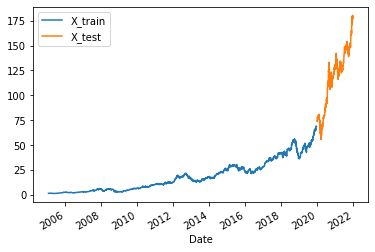

<Figure size 1440x1080 with 0 Axes>

In [26]:
X_train['Close'].plot(kind='line')
X_test['Close'].plot(kind='line')

plt.legend(['X_train', 'X_test'])
plt.figure(figsize=(20,15))
plt.show()

In [27]:
# 학습 데이터, 정답 데이터 -> 월~목(4일씩)까지 1set 
# LSTM -> Numpy 배열 
# StandardScaler 사용
def Scaler_to_np(df):
    df_list = []
    df = np.array(df) 
    for i in range(0, len(df) - 3, 4): 
        df_s = df[i : i + 4] 
        scaler = StandardScaler()
        df_scaler = scaler.fit_transform(df_s)
        df_list.append(df_scaler)
    
    return np.array(df_list)

In [28]:
X_train_array = Scaler_to_np(X_train)
X_test_array = Scaler_to_np(X_test)

print(X_train_array.shape)
print(X_test_array.shape)

(804, 4, 7)
(108, 4, 7)


In [29]:
y_train_new = y_train[3::4]
y_test_new = y_test[3::4]
print(len(y_train_new))
print(len(y_test_new))

804
108


### LSTM 모델 생성 

In [30]:
def gen_lstm_compile(df):
    model = Sequential()
    model.add(LSTM(256, activation='relu', batch_input_shape=(None, df.shape[1], df.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [31]:
# 시계열데이터 모델검증하기 (Timeseries Validation) -> TimeSeriesSpilt
valid_scores = [] # 4번의 교차 검증의 결과 저장 
tscv = TimeSeriesSplit(n_splits=4)

In [32]:
for fold, (train_indices, value_indices) in enumerate(tscv.split(X_train_array)):
    X_train, X_valid = X_train_array[train_indices], X_train_array[value_indices]
    y_train, y_valid = y_train_new[train_indices], y_train_new[value_indices]
    
    model = gen_lstm_compile(X_train)
    model.fit(X_train, y_train, epochs=10, batch_size=64)
    
    y_pred = model.predict(X_valid)
    
    y_pred = np.where(y_pred < 0.5, 0, 1)
    
    score = accuracy_score(y_valid, y_pred)
    print(f"fold {fold} Score: {score}")
    
    valid_scores.append(score)

2022-03-18 16:51:41.547171: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
3/3 [==============================] - 1s 10ms/step - loss: 0.6942 - accuracy: 0.5061
Epoch 2/10
3/3 [==============================] - 0s 11ms/step - loss: 0.6899 - accuracy: 0.5183
Epoch 3/10
3/3 [==============================] - 0s 13ms/step - loss: 0.6882 - accuracy: 0.5183
Epoch 4/10
3/3 [==============================] - 0s 13ms/step - loss: 0.6867 - accuracy: 0.5427
Epoch 5/10
3/3 [==============================] - 0s 11ms/step - loss: 0.6825 - accuracy: 0.5549
Epoch 6/10
3/3 [==============================] - 0s 12ms/step - loss: 0.6815 - accuracy: 0.5549
Epoch 7/10
3/3 [==============================] - 0s 12ms/step - loss: 0.6813 - accuracy: 0.5732
Epoch 8/10
3/3 [==============================] - 0s 11ms/step - loss: 0.6751 - accuracy: 0.6341
Epoch 9/10
3/3 [==============================] - 0s 13ms/step - loss: 0.6732 - accuracy: 0.5793
Epoch 10/10
3/3 [==============================] - 0s 12ms/step - loss: 0.6764 - accuracy: 0.5610
fold 0 Score: 0.625
Epoch 1/1

In [33]:
print(f"valid_scores: {valid_scores}")
cv_score = np.mean(valid_scores)
print(f"cv_score: {cv_score}")

valid_scores: [0.625, 0.48125, 0.55, 0.5]
cv_score: 0.5390625


In [34]:
model = gen_lstm_compile(X_train_array)
r = model.fit(X_train_array, y_train_new, epochs=10, batch_size=64)

Epoch 1/10
13/13 [==============================] - 1s 10ms/step - loss: 0.6910 - accuracy: 0.5361
Epoch 2/10
13/13 [==============================] - 0s 11ms/step - loss: 0.6901 - accuracy: 0.5274
Epoch 3/10
13/13 [==============================] - 0s 10ms/step - loss: 0.6847 - accuracy: 0.5348
Epoch 4/10
13/13 [==============================] - 0s 10ms/step - loss: 0.6829 - accuracy: 0.5485
Epoch 5/10
13/13 [==============================] - 0s 11ms/step - loss: 0.6878 - accuracy: 0.5510
Epoch 6/10
13/13 [==============================] - 0s 10ms/step - loss: 0.6781 - accuracy: 0.5771
Epoch 7/10
13/13 [==============================] - 0s 10ms/step - loss: 0.6774 - accuracy: 0.5697
Epoch 8/10
13/13 [==============================] - 0s 12ms/step - loss: 0.6755 - accuracy: 0.5945
Epoch 9/10
13/13 [==============================] - 0s 12ms/step - loss: 0.6742 - accuracy: 0.5871
Epoch 10/10
13/13 [==============================] - 0s 10ms/step - loss: 0.6664 - accuracy: 0.5933


In [35]:
X_test_array

array([[[-1.34164079, -0.96891886, -1.15652296, ..., -0.68278333,
         -0.22871013, -0.89555548],
        [-0.4472136 , -0.73721011, -0.18786477, ..., -1.00348813,
         -1.51268655,  1.52112732],
        [ 0.4472136 ,  0.12427115, -0.25610357, ...,  0.09981119,
          0.60307931, -0.89950646],
        [ 1.34164079,  1.58185782,  1.60049131, ...,  1.58646028,
          1.13831737,  0.27393462]],

       [[ 1.52127766, -1.58775073, -1.35768914, ..., -0.98853152,
          0.05836571,  0.11797866],
        [-1.18321596,  0.7161069 ,  0.57101611, ...,  1.63472487,
          1.558979  , -1.55252634],
        [-0.50709255,  0.97728154,  1.26545851, ..., -0.05692274,
         -1.1680301 ,  1.24014069],
        [ 0.16903085, -0.10563771, -0.47878548, ..., -0.58927061,
         -0.44931462,  0.19440699]],

       [[ 0.63245553, -0.16434864,  0.28125413, ...,  0.02165152,
          0.32433042,  0.17429573],
        [ 1.26491106,  0.92791534,  1.0572771 , ...,  0.94224197,
          0.

In [36]:
pred = model.predict(X_test_array)
pred[:10]

array([[0.5737016 ],
       [0.55212367],
       [0.70557976],
       [0.54823095],
       [0.5184177 ],
       [0.5455609 ],
       [0.5936395 ],
       [0.45420787],
       [0.5788279 ],
       [0.5499177 ]], dtype=float32)

In [38]:
pred = np.where(pred < 0.5, 0, 1)
pred[:10]

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1]])

In [39]:
print(f"accuracy= {accuracy_score(y_true=y_test_new, y_pred=pred)}")

accuracy= 0.5092592592592593


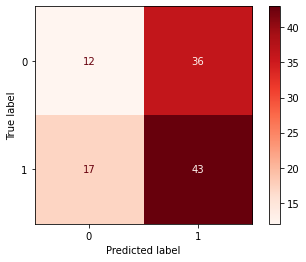

In [40]:
cm = confusion_matrix(y_test_new, pred)
cmp = ConfusionMatrixDisplay(cm)
cmp.plot(cmap=plt.cm.Reds)

In [ ]:
# 주가 종목 선택 후, 2005~01-01 ~ 2022-02-28(학습, 검증 데이터) 까지 데이터 분석/예측 후, (상승/하락 예측)
# 2022-03-01 ~ 2022-03-18(테스트 데이터)) 이후의 데이터 정확도 확인 
# 일요일까지 제출 